<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Transfer_learning/TVshow_characters_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons characters classification

## Install libs

In [1]:
!pip install kaggle

## imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import torch
import torch.nn as nn

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim import Adam, AdamW, lr_scheduler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm, tqdm_notebook

### Create folder and download the dataset

If you want to follow this track, don't forget to put **your** kaggle API (download kaggle.json from kaggle.com) in the current dirrectory (I assume its 'content' for you)

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c journey-springfield
!unzip -q journey-springfield.zip

 99% 518M/521M [00:25<00:00, 24.4MB/s]
100% 521M/521M [00:25<00:00, 21.7MB/s]


If you cannot perform the actions above or you don't have kaggle account (what are you doing here then?) - uncomment and use the code below. Of course you need to mound the drive and upload your version of dataset

In [7]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

### Sort data in order and get labels

In [5]:
path_train = Path('./train/')
path_test = Path('./testset/')

train_val_files = sorted(list(path_train.rglob('*.jpg')))
test_files = sorted(list(path_test.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

### Check characters distribution in train dataset

In [6]:
def plot_character_distribution(train_labels):
    plt.figure(figsize=(12,6))
    counts = pd.Series(train_labels).value_counts()
    sns.barplot(x=counts.sort_values(ascending=False), y=counts.keys())
    plt.tight_layout()
    plt.show()
    return counts

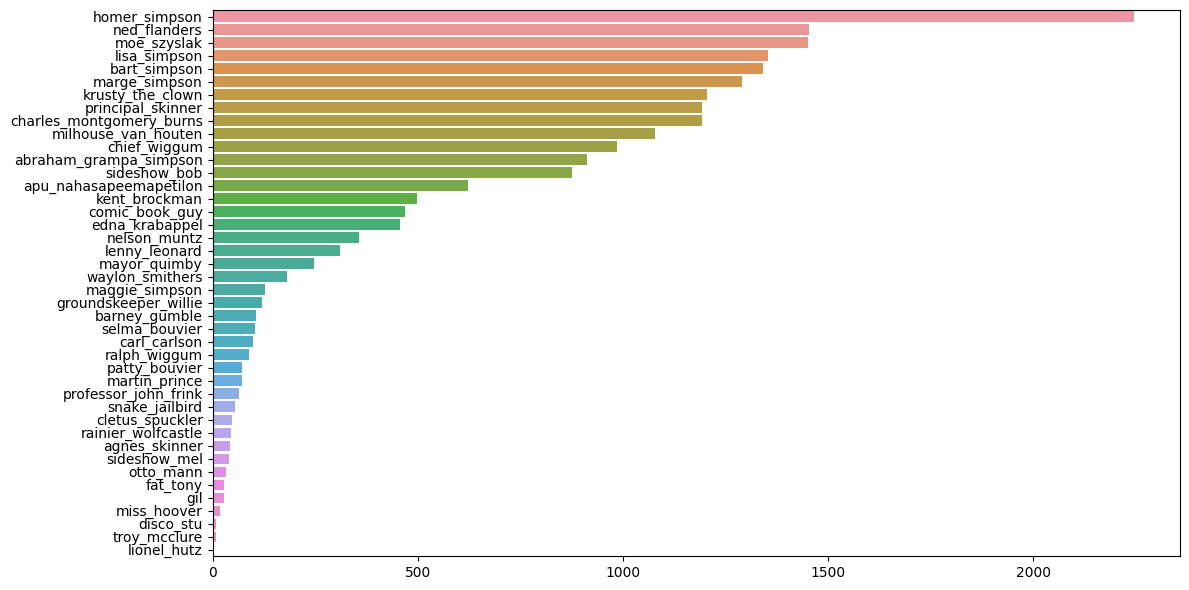

In [7]:
charnums = plot_character_distribution(train_val_labels)

### Split train labels into train and val data with stratification

In [8]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

## Load images as Datasets

In [9]:
class CFG:
  rescale_image = 224
  imagenet_means = [0.485, 0.456, 0.406]
  imagenet_stds = [0.229, 0.224, 0.225]
  batchsize = 64
  device = lambda: 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = np.array(CFG.imagenet_stds) * inp.numpy().transpose(
                                      (1, 2, 0)) + np.array(CFG.imagenet_means)
    inp = np.clip(inp, 0, 1)

    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
class CustomDataset(Dataset):
  def __init__(self, files, train=True):
    super().__init__()
    self.files = sorted(files)
    self.le = LabelEncoder()
    self.train_mode = train
    if train:
      self.labels = self.l_encode

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    filename = self.files[idx]
    img = self._load_sample(filename)
    img = self._get_augs(img) if self.train_mode else self._get_transforms(img)
    return self._get_xy(img, idx)


  @staticmethod
  def _load_sample(name):
    img = Image.open(name)
    img.load()
    img = img.resize((CFG.rescale_image, CFG.rescale_image))
    return img

  @property
  def l_encode(self):
    labels = [path.parent.name for path in self.files]
    self.le.fit(labels)
    with open('le.pkl', 'wb') as f:
      pickle.dump(self.le, f)
    return labels


  def _get_xy(self, x, y_idx):
    if self.train_mode:
      label = self.labels[y_idx]
      label_id = self.le.transform([label])
      return x, label_id.item()
    else:
      return x


  @staticmethod
  def _get_augs(img):
    percentile = CFG.rescale_image//10
    transform = transforms.Compose([transforms.CenterCrop(size=CFG.rescale_image),
                                    transforms.RandomPerspective(),
                                    transforms.RandomCrop(CFG.rescale_image - percentile),
                                    transforms.RandomResizedCrop(CFG.rescale_image),
                                    transforms.RandomRotation(degrees=(
                                                      -percentile, percentile)),
                                    transforms.RandomHorizontalFlip(p=0.9),
                                    transforms.Resize(size=(CFG.rescale_image,
                                                            CFG.rescale_image)),
                                    transforms.Lambda(lambda x: np.array(
                                                    x, dtype='float32') / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize(CFG.imagenet_means,
                                                         CFG.imagenet_stds)])
    return transform(img)



  @staticmethod
  def _get_transform(img):
    transform = transforms.Compose([transforms.Resize(size=(CFG.rescale_image,
                                                            CFG.rescale_image)),
                                    transforms.Lambda(lambda x: np.array(
                                                      x, dtype='float32') / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize(CFG.imagenet_means,
                                                         CFG.imagenet_stds)])
    return transform(img)



In [12]:
train_dataset = CustomDataset(train_files)
val_dataset = CustomDataset(val_files)
trainval_dataset = CustomDataset(train_val_files)
test_dataset = CustomDataset(test_files, False)

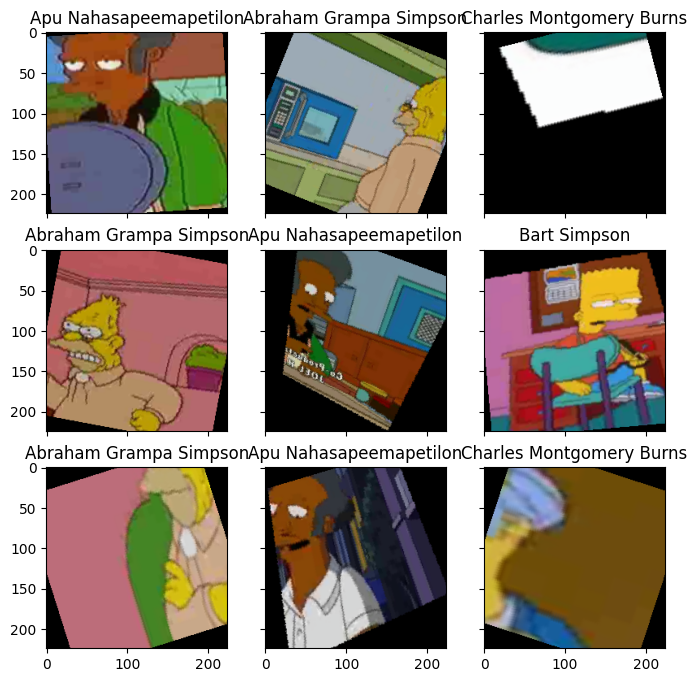

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.le.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Using weighted sampler

kudos to [wervlad](https://www.kaggle.com/code/wervlad/baseline-2fc-augmentations) [vladislavzenin](https://www.kaggle.com/code/vladislavzenin/weightedrandomsampler) and [ndyarrrr](https://www.kaggle.com/code/ndyarrrr/1-0-score-with-baseline-model-3fc) for the WightedSampler

#### vladislavzenin and wervlad's approach

In [14]:
weights_count = {k: 1/v for k,v in charnums.items()}
weights_samples = [weights_count[label] for label in train_val_labels]
N_vw = charnums.max() * len(weights_count)

train_sampler_1 = WeightedRandomSampler(weights_samples, num_samples=int(N_vw), replacement=True)
train_loader_1 = DataLoader(trainval_dataset, batch_size=CFG.batchsize, sampler=train_sampler_1, num_workers=2)

#### ndyarrrr's approach

In [15]:
count_weights = {key: 1/value for key, value in charnums.items()}
sample_weights = len(train_val_files) * [0]

for i, (data, label) in enumerate(tqdm(trainval_dataset)):
    label_weight = count_weights[trainval_dataset.le.inverse_transform([label])[0]]
    sample_weights[i] = label_weight

100%|██████████| 20933/20933 [02:54<00:00, 119.78it/s]


In [16]:
N_n = charnums.max() * len(count_weights)
print(N_n)
train_sampler_2 = WeightedRandomSampler(sample_weights, num_samples=int(N_n), replacement=True)
train_dataloader_2 = DataLoader(trainval_dataset, batch_size=CFG.batchsize*2, sampler=train_sampler_2) #one worker twice tha batchsize

94332


#### compare dicts in two approaches

In [17]:
weights_count == count_weights

True

## Write a simple CNN model

In [18]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(96 * 5 * 5, 2500)
        self.fc2 = nn.Linear(2500, 5000)
        self.fc3 = nn.Linear(5000, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        relu = nn.ReLU()
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x)

        return x